In [21]:
# STEP 1: Install Required Libraries (Run this cell in Google Colab)
!pip install requests beautifulsoup4 nltk wordcloud matplotlib pandas textblob scikit-learn imbalanced-learn

# STEP 2: Import Libraries
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# STEP 3: Scrape Text from Wikipedia
url = "https://en.wikipedia.org/wiki/Argentina"  # Change to your country if needed
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract all paragraphs and join text
text = ' '.join([p.text for p in soup.find_all('p')])
print("Raw Text Sample:\n", text[:500])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Raw Text Sample:
 
 Argentina,[C] officially the Argentine Republic,[A][D] is a country in the southern half of South America. It covers an area of 2,780,085 km2 (1,073,397 sq mi),[B] making it the second-largest country in South America after Brazil, the fourth-largest country in the Americas, and the eighth-largest country in the world. Argentina shares the bulk of the Southern Cone with Chile to the west, and is also bordered by Bolivia and Paraguay to the north, Brazil to the northeast, Uruguay and the South 


In [22]:
# STEP 4: Clean the Text
text = re.sub(r'\[.*?\]', '', text)  # Remove references like [1]
text = re.sub(r'[^a-zA-Z. ]', '', text)  # Remove non-alphabetic characters
text = text.lower()
nltk.download('punkt_tab')
# STEP 5: Sentence Tokenization
sentences = sent_tokenize(text)
print("Sample Sentences:", sentences[:5])

# STEP 6: Analyze Sentiment using TextBlob
def analyze_sentiment(sentence):
    polarity = TextBlob(sentence).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

sentiments = [analyze_sentiment(s) for s in sentences]
df = pd.DataFrame({'sentence': sentences, 'sentiment': sentiments})
print(df.head())


Sample Sentences: [' argentina officially the argentine republic is a country in the southern half of south america.', 'it covers an area of km sqmi making it the secondlargest country in south america after brazil the fourthlargest country in the americas and the eighthlargest country in the world.', 'argentina shares the bulk of the southern cone with chile to the west and is also bordered by bolivia and paraguay to the north brazil to the northeast uruguay and the south atlantic ocean to the east and the drake passage to the south.', 'argentina is a federal state subdivided into twentythree provinces and one autonomous city which is the federal capital and largest city of the nation buenos aires.', 'the provinces and the capital have their own constitutions but exist under a federal system.']
                                            sentence sentiment
0   argentina officially the argentine republic i...  negative
1  it covers an area of km sqmi making it the sec...   neutral
2  a

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
# STEP 7: Word Tokenization
words = word_tokenize(text)

# STEP 8: Remove Stopwords
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
print("Filtered Words Sample:", filtered_words[:20])


Filtered Words Sample: ['argentina', 'officially', 'argentine', 'republic', 'country', 'southern', 'half', 'south', 'america', 'covers', 'area', 'km', 'sqmi', 'making', 'secondlargest', 'country', 'south', 'america', 'brazil', 'fourthlargest']


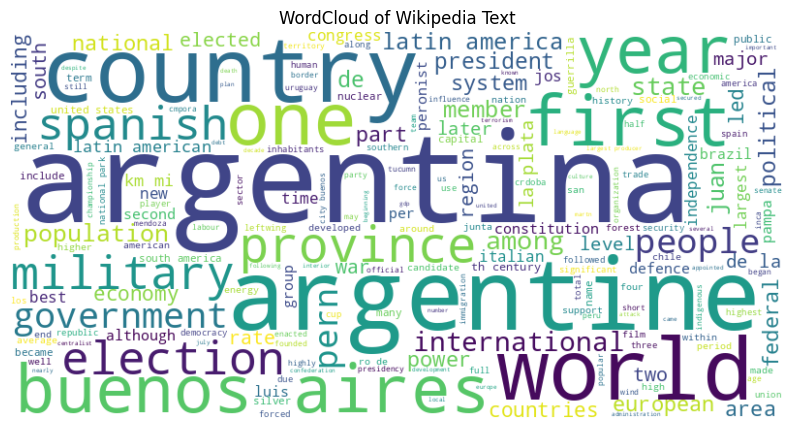

In [24]:
# Join the words for WordCloud input
all_words = ' '.join(filtered_words)

# Generate WordCloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Wikipedia Text")
plt.show()


Top 15 Frequent Words: [('argentina', 124), ('argentine', 71), ('country', 60), ('world', 49), ('de', 48), ('one', 40), ('first', 38), ('aires', 36), ('buenos', 35), ('latin', 33), ('national', 32), ('south', 31), ('also', 28), ('people', 28), ('military', 27)]


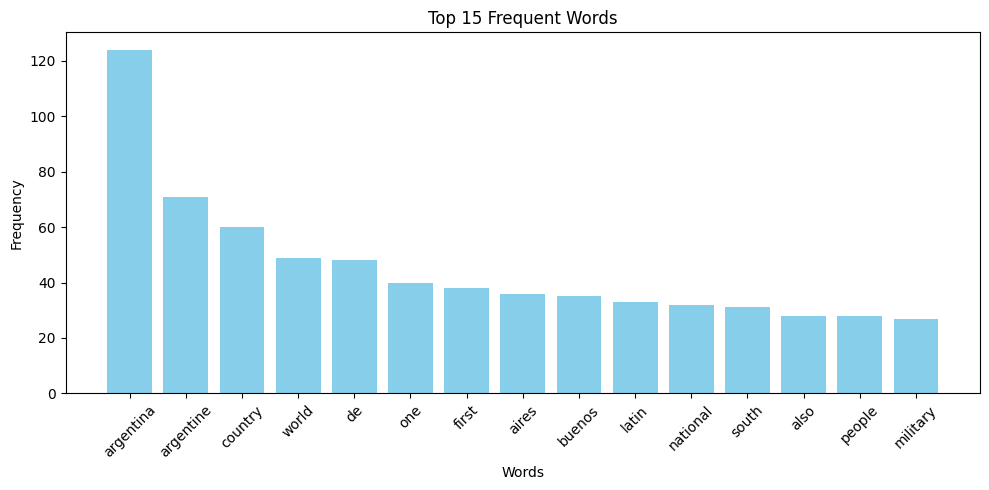

In [25]:
from collections import Counter

# Count word frequencies
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(15)
print("Top 15 Frequent Words:", most_common_words)

# Plotting frequent words
words, freqs = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color='skyblue')
plt.title("Top 15 Frequent Words")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF on the 'sentence' column
X = tfidf_vectorizer.fit_transform(df['sentence'])
print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (573, 3521)


In [27]:
# Map sentiment labels to binary
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Drop neutral entries
df_binary = df.dropna(subset=['label'])
X_binary = X[df_binary.index]
y_binary = df_binary['label'].astype(int)

print("Data shape after removing neutral sentiments:", X_binary.shape, y_binary.shape)


Data shape after removing neutral sentiments: (359, 3521) (359,)


In [28]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance dataset
X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

print("After SMOTE: ", X_resampled.shape, y_resampled.shape)


After SMOTE:  (512, 3521) (512,)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_resampled, y_resampled)

y_pred_logreg = logreg_model.predict(X_resampled)
print("📊 Logistic Regression Performance:")
print(classification_report(y_resampled, y_pred_logreg))


📊 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       256
           1       1.00      1.00      1.00       256

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



In [30]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_resampled, y_resampled)

y_pred_dt = dt_model.predict(X_resampled)
print("🌳 Decision Tree Performance:")
print(classification_report(y_resampled, y_pred_dt))


🌳 Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       256
           1       1.00      1.00      1.00       256

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)

y_pred_rf = rf_model.predict(X_resampled)
print("🌲 Random Forest Performance:")
print(classification_report(y_resampled, y_pred_rf))


🌲 Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       256
           1       1.00      1.00      1.00       256

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()
gb_model.fit(X_resampled, y_resampled)

y_pred_gb = gb_model.predict(X_resampled)
print("🚀 Gradient Boosting Performance:")
print(classification_report(y_resampled, y_pred_gb))


🚀 Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       256
           1       0.97      1.00      0.99       256

    accuracy                           0.99       512
   macro avg       0.99      0.99      0.99       512
weighted avg       0.99      0.99      0.99       512



In [33]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

y_pred_nb = nb_model.predict(X_resampled)
print("🧠 Naïve Bayes Performance:")
print(classification_report(y_resampled, y_pred_nb))


🧠 Naïve Bayes Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       256
           1       1.00      0.97      0.99       256

    accuracy                           0.99       512
   macro avg       0.99      0.99      0.99       512
weighted avg       0.99      0.99      0.99       512



In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_resampled.toarray(), y_resampled)

y_pred_knn = knn_model.predict(X_resampled.toarray())
print("👥 K-Nearest Neighbors Performance:")
print(classification_report(y_resampled, y_pred_knn))


👥 K-Nearest Neighbors Performance:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       256
           1       1.00      0.04      0.08       256

    accuracy                           0.52       512
   macro avg       0.75      0.52      0.38       512
weighted avg       0.75      0.52      0.38       512



In [35]:
import joblib

# Save the trained model
joblib.dump(rf_model, 'random_forest_sentiment_model.pkl')

# Save the TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [36]:
import os
import signal

# Find and kill existing ngrok processes
for line in os.popen("ps ax | grep ngrok | grep -v grep"):
    fields = line.split()
    pid = fields[0]
    os.kill(int(pid), signal.SIGKILL)

In [37]:
!pip install streamlit -q

In [38]:
!wget -q -O - ipv4.icanhazip.com

35.221.203.214


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.203.214:8501

your url is: https://lucky-parrots-write.loca.lt
/content/app.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Polarity", "Subjectivity"], y=[polarity, subjectivity], palette='coolwarm')
